# Background

This notebook is based on <br>
**Emily S. C Ching, P. H. Tam, "[Effects of hidden nodes on the reconstruction of bidirectional networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.98.062318)", Phys. Rev. E 98, 062318 (2018)** [1] <br>

The authors in [1] consider a weighted bidirectional network of $N$ nodes, each has state variable $x_{i}(t)$ governed by the coupled stochastic differential equations (SDEs).

\begin{align}
    \frac{dx_{i}}{dt} \; = \; f(x_{i}) \; + \; \sum_{j \neq i}\, g_{ij}A_{ij}h(x_{j} - x_{i}) \; + \; \eta_{i}
\end{align}
for $i = 1, 2, \dots, N$.
* $f(x_{i})$: intrinsic dynamics of node $i$ with a stable fixed point $X_{0}$
* $A_{ij}$: adjacency matrix element
* $g_{ij}$: coupling strength
* $h$: diffusive-like coupling function with $h^{\prime}(0) > 0$ and $h(-z) = -h(z)$
* $\eta_{i}$: Gaussian white noise with $\overline{\eta}_{i} = 0$ and $\overline{\eta_{i}(t) \eta_{j}(t^{\prime})} = \sigma^{2}_{n}\, \delta_{ij} \, \delta(t - t^{\prime})$.

As $t \to \infty$, dynamics of nodes fluctuates around the stable fixed point $X_{0}$ (Stationary Dynamics)

The aim of network reconstruction is to infer the network connectivity $A_{ij}$ from the dynamics of nodes $x_{i}(t)$. This is known as inverse problem. 


# Problem
The authors consider a realistic situation in which some of the nodes are not available for measurements. They asked the following question:

Given only $n < N$ nodes available for measurement, is it possible to infer the network connectivity *among the measured nodes*? [1]


# Solution
The authors obtained an analytical result [1]
\begin{align}
    (\Sigma^{-1}_{m})_{ij} \; = \; - \frac{2h^{\prime}(0)}{\sigma^{2}_{n}} \Big( g_{ij} A_{ij} + C_{ij} \Big) \tag{2}
\end{align}
for $i \neq j$, and $i, j = 1, 2, \dots, n < N$
* $\mathbf{\Sigma^{-1}_{m}}:$ inverse covariance matrix **formed by the measured nodes only**
* $A_{ij}$: adjacency matrix element **among the measured nodes**
* $g_{ij}$: coupling strength **among the measured nodes**
* $C_{ij}$: effect of hidden nodes acting on the measured node $i$ and $j$<br>


**Remarks**
-  Here $i, j$ represents node indices of measured nodes, and they do not necessarily mean the first $n$ node indices of the whole network.
- The authors in [1] consider $h^{\prime}(0) = 1$

This equation shows that even if there are some nodes not available for measurements, $(\Sigma^{-1}_{m})_{ij}$ is still related to $g_{ij}A_{ij}$, the network connectivity among the measured nodes. The details of $C_{ij}$ can be found in [1].

In [1]:
# Import modules 
import numpy as np
import matplotlib.pyplot as plt

# Import the python scripts 
import tools
import adjacency
import assign_weights
import network_tools
import choose_nodes
import dynamics_tools
import simulations
import reconstructions
import compare_results

%matplotlib inline

# Network for simulation

First, we choose our network as ER random network with Gaussian coupling.

In [2]:
# Set random seed
np.random.seed(seed=22)

# Construct a weighted random network with Gaussian coupling

# Total number of node
N = 100

# Connection probability
p = 0.2

# Mean value of Gaussian coupling
mean = 10

# Standard deviation of Gaussian coupling
std = 2


# Construct a ER unweighted bidirectional random network
A = adjacency.er_random(N, p)

# Construct the corresponding weighted network with Gaussian coupling strength
W = assign_weights.gaussian(A, mean, std)

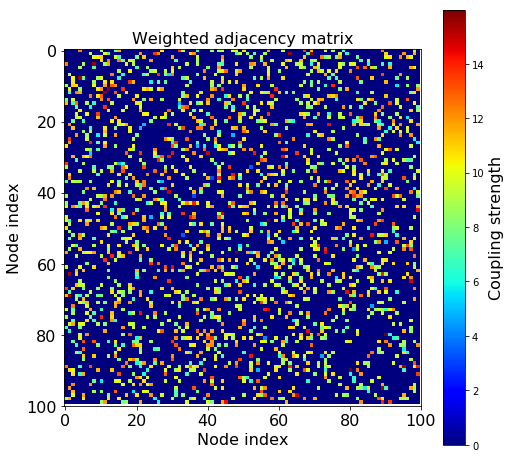

In [3]:
# Image plot the weighted adjacency matrix
fig = plt.figure(figsize=(8, 8))
plt.imshow(W, cmap='jet')
cbar = plt.colorbar()
cbar.set_label("Coupling strength", fontsize=16)
plt.title("Weighted adjacency matrix", fontsize=16)
plt.xlabel("Node index", fontsize=16)
plt.ylabel("Node index", fontsize=16)
plt.xticks(np.arange(0, 120, 20), fontsize=16)
plt.yticks(np.arange(0, 120, 20), fontsize=16)

plt.show()

# Stationarity checking
To obtain the analytic result in [1], the dynamics has to be stationary. For this class of dynamics to be stationary, we check the eigenvalue of the weighted Laplacian matrix $\mathbf{\mathcal{L}}$

\begin{align}
    \mathcal{L}_{ij} \; = \; \sum_{k} (g_{ik}A_{ik}) \, \delta_{ij} \;\; - \;\; g_{ij}A_{ij} \tag{3}
\end{align}

For Eq. (1) to have stationary dynamics, one of the conditions is that $\mathbf{\mathcal{L}}$ should have no negative eigenvalues.

In [4]:
_ = dynamics_tools.stationary_check(W)

Absolute minimum eigenvalue of L =  4.510963815711182e-14
The dynamics would probably fluctuate around a stable fixed point


# Dynamics simulation

In this demo, we choose:
1. $f(x) \; = \; r x(1-x)$
2. $h(x-y) \; = \;  y - x$

Hence, the coupled SDEs becomes

\begin{align}
    \frac{dx_{i}}{dt} \; = \; rx_{i}(1-x_{i}) \; - \; \sum_{j=1}^{N} \mathcal{L}_{ij} \, x_{j} \; + \; \eta_{i} \tag{4}
\end{align}

In the following, we generate the dynamics of $x_{i}(t)$ by solving the coupled SDEs using Euler-Maruyama method and obtain $\mathbf{\Sigma}$, `cov` (the covariance matrix of the whole network)

In [5]:
# Set random seed
np.random.seed(13)


# Parameter for f(x)
r = 10

# Noise strength
sigma = 1

# Integration step
int_dt = 5e-5

# Sampling step
sample_dt = 5e-4

# Time step to begin sampling
sample_start = int(5e3)

# Total number of data points to compute covariance matrix
data_num = int(2e6)


# cov: covariance matrix formed by ALL the nodes
# x_ts: sampled time series of the first node
cov, x_ts = simulations.get_covariance(W, r, sigma, int_dt, sample_dt, sample_start, data_num, get_ts=True)

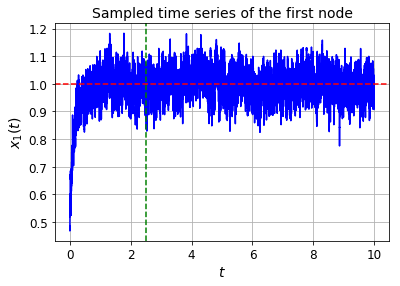

In [6]:
# Plot the sampled time series of the first node

t = np.arange(len(x_ts))*sample_dt

# We plot only part of the time series for better visualization
plt.plot(t[:20000], x_ts[:20000], color='b')
plt.axvline(x=sample_start*sample_dt, color='g', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.title("Sampled time series of the first node", fontsize=14)
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$x_{1}(t)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Select measured nodes and hidden nodes

In the following, we choose $n = 30$ nodes from $N=100$ nodes as measured nodes randomly.<br>

With the selected node indices `measure_id` and `hidden_id`, we can extract $\mathbf{\Sigma_{m}}$ from $\mathbf{\Sigma}$, which is `cov` generated from the above simulation. Finally, we obtain $\mathbf{\Sigma_{m}^{-1}}$, `cov_m_inv`

In [7]:
# Set random seed
np.random.seed(19)

# Number of measured nodes
n = 30

# Get the node indices that corresponds to measured nodes and hidden nodes
measure_id, hidden_id = choose_nodes.random(N, n)

# cov_m_inv is the inverse covariance matrix formed by the measured nodes only
_, cov_m_inv = dynamics_tools.inverse_covariance(cov, measure_id, hidden_id)

# Visualization
The histogram in this case shows that $(\Sigma_{m}^{-1})_{ij}$ for $i \neq j$ is bi-modal distributed according to $A_{ij} = 0$ or $A_{ij} = 1$.

In [8]:
# Get the network connectivity among the measured nodes
_, W_m, _, _, _ = tools.matrix_rearrange(W, measure_id, hidden_id)
W_m_off = tools.off_diag_upper(W_m)

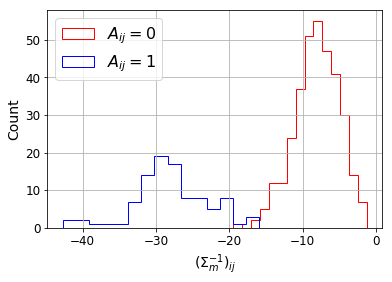

In [9]:
# Select only the off-diagonal elements (upper triangle)
data_hidden = tools.off_diag_upper(cov_m_inv)

# Separate the data into unconnected and connected as if we already known the underlying network
ucon_hidden = data_hidden[W_m_off == 0]
conn_hidden = data_hidden[W_m_off != 0]

# Histogram of (\Sigma_{m}^{-1})_{ij}
plt.hist(ucon_hidden, bins=15, color='r', histtype='step', label=r"$A_{ij} = 0$")
plt.hist(conn_hidden, bins=15, color='b', histtype='step', label=r"$A_{ij} = 1$")
plt.legend(fontsize=16)
plt.xlabel(r"$(\Sigma_{m}^{-1})_{ij}$", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.show()

# Network reconstruction
$(\Sigma_{m}^{-1})_{ij}$ for $i \neq j$ is clustered using **k-means clustering.**

Clustered data with centroid close to zero are reconstructed as unconnected pairs. Otherwise, they are reconstructed as connected pairs.

In [10]:
# k-means cluster the data and 
# returns the node indices that reconstructed to be connected pairs
row_conn_triu, col_conn_triu = reconstructions.kmeans(data_hidden, k=2)

In [11]:
# Get the reconstructed adjacency matrix from the reconstructed node indices above
A_reco = reconstructions.reconstruct(n, row_conn_triu, col_conn_triu)

# Reconstructed result

Let's compare the reconstructed adjacency matrix with the actual adjacency matrix among the measured nodes

In [12]:
# Get the original adjacency matrix among the measured nodes
A_m = W_m
A_m = (A_m != 0).astype('int')
# Compute the error rates
compare_results.error_rates(A_m, A_reco)

Number of bidirectional links = 97
Number of false positive = 1
Number of false negative = 3
False positive rate = 1.0309%
False negative rate = 3.0928%


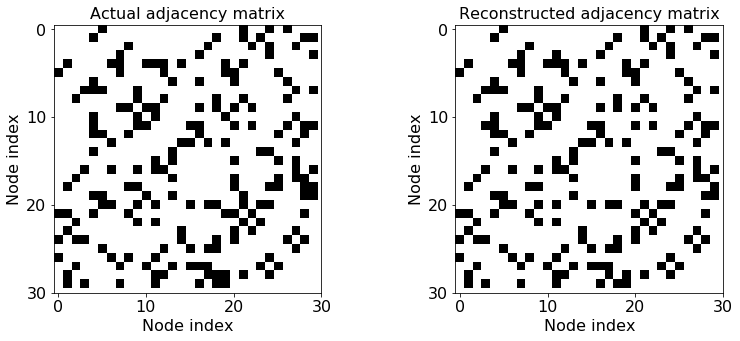

In [13]:
# Image plot the actual and reconstructed adjacency matrix
fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
fig.subplots_adjust(wspace=0.5)

# Actual adjacency matrix
plt.imshow(A_m, cmap='Greys')
plt.title("Actual adjacency matrix", fontsize=16)
plt.xlabel("Node index", fontsize=16)
plt.ylabel("Node index", fontsize=16)
plt.xticks(np.arange(0, n+10, 10), fontsize=16)
plt.yticks(np.arange(0, n+10, 10), fontsize=16)

# Reconstructed adjacency matrix
plt.subplot(1, 2, 2)
plt.imshow(A_reco, cmap='Greys')
plt.title("Reconstructed adjacency matrix", fontsize=16)
plt.xlabel("Node index", fontsize=16)
plt.ylabel("Node index", fontsize=16)
plt.xticks(np.arange(0, n+10, 10), fontsize=16)
plt.yticks(np.arange(0, n+10, 10), fontsize=16)

plt.show()